# San Francisco crime analysis projects

link to data:
https://data.sfgov.org/Public-Safety/sf-data/skgt-fej3/data

# Step0: set up spark envir and reading in dataset

In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install ggplot
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ggplot
import warnings
warnings.filterwarnings('ignore')


import os
os.environ["PYSPARK_PYTHON"] = "python3"

/usr/local/lib/python3.6/dist-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/local/lib/python3.6/dist-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 14.0MB/s 


In [0]:
file = drive.CreateFile({'id':'1kYi5k-T8xISb_joI_ZJWJHDGKjTDgJ-A'}) 
file.GetContentFile('sf_crime.csv')

In [8]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
sf_crime = spark.read.format("csv").option("header", "true").load("sf_crime.csv")
sf_crime.createOrReplaceTempView("sf_crime")
sf_crime.show(5)

+----------+---------------+--------------------+---------+----------+-----+----------+----------+--------------------+-----------------+----------------+--------------------+--------------+
|IncidntNum|       Category|            Descript|DayOfWeek|      Date| Time|PdDistrict|Resolution|             Address|                X|               Y|            Location|          PdId|
+----------+---------------+--------------------+---------+----------+-----+----------+----------+--------------------+-----------------+----------------+--------------------+--------------+
| 150060275|   NON-CRIMINAL|       LOST PROPERTY|   Monday|01/19/2015|14:00|   MISSION|      NONE|18TH ST / VALENCI...| -122.42158168137|37.7617007179518|(37.7617007179518...|15006027571000|
| 150098210|        ROBBERY|ROBBERY, BODILY F...|   Sunday|02/01/2015|15:45|TENDERLOIN|      NONE|300 Block of LEAV...|-122.414406029855|37.7841907151119|(37.7841907151119...|15009821003074|
| 150098210|        ASSAULT|AGGRAVATED ASSAUL

# Count the number of crimes each category

Larceny/theft is the top frequent crime in SF.

In [9]:
crimeCategory = spark.sql("SELECT  category, COUNT(*) AS Count FROM sf_crime GROUP BY category ORDER BY Count DESC")
crimeCategory.show(5)

+--------------+------+
|      category| Count|
+--------------+------+
| LARCENY/THEFT|480448|
|OTHER OFFENSES|309358|
|  NON-CRIMINAL|238323|
|       ASSAULT|194694|
| VEHICLE THEFT|126602|
+--------------+------+
only showing top 5 rows



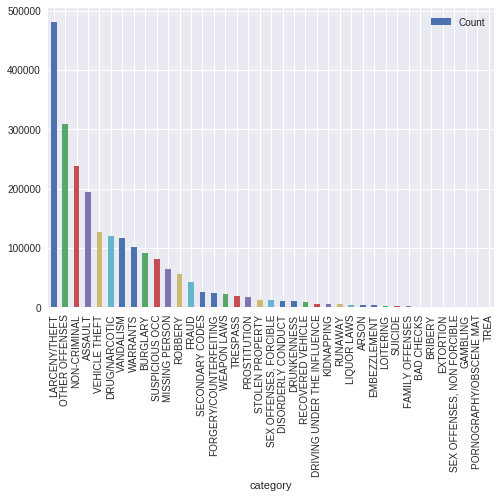

In [10]:
crimesCategory_pd = crimeCategory.toPandas()
crimesCategory_pd.plot(kind='bar',x='category',y='Count')

# Counts the number of crimes for different district
Southern, Misson and Northern are top 3 dangerous district.

In [11]:
crimePdDistrict = spark.sql("SELECT  PdDistrict, COUNT(*) AS Count FROM sf_crime GROUP BY PdDistrict ORDER BY Count DESC")
crimePdDistrict.show(5)

+----------+------+
|PdDistrict| Count|
+----------+------+
|  SOUTHERN|399785|
|   MISSION|300076|
|  NORTHERN|272713|
|   CENTRAL|226255|
|   BAYVIEW|221000|
+----------+------+
only showing top 5 rows



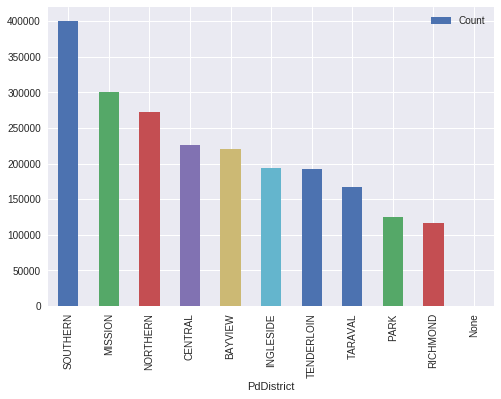

In [12]:
crimesPdDistrict_pd = crimePdDistrict.toPandas()
crimesPdDistrict_pd.plot(kind='bar',x='PdDistrict',y='Count')

# Count the number of crimes each "Sunday" at "SF downtown"

This area, downtown, is relatively safe as the average number of crimes happened to be lower than 4. It is recommended to travel in SF downtown on Sunday, but always be careful.

In [13]:
crimeSundayDowntown = spark.sql("SELECT Date, COUNT(*) as count \
                                FROM sf_crime \
                                WHERE X>=-122.4087 AND X <= -122.3933 AND Y<=37.7966 AND Y>= 37.7936 AND DayOfWeek = 'Sunday'\
                                GROUP BY Date ORDER BY count DESC")
crimeSundayDowntown.show()

+----------+-----+
|      Date|count|
+----------+-----+
|01/01/2006|   18|
|06/24/2012|   13|
|04/13/2014|   13|
|02/14/2010|   13|
|01/25/2015|   12|
|04/21/2013|   12|
|07/31/2016|   12|
|07/13/2014|   12|
|08/18/2013|   11|
|12/11/2016|   11|
|05/25/2014|   11|
|11/25/2007|   11|
|08/24/2003|   11|
|11/14/2004|   10|
|04/12/2009|   10|
|09/09/2007|   10|
|09/12/2010|   10|
|10/24/2010|   10|
|09/30/2012|   10|
|01/11/2015|   10|
+----------+-----+
only showing top 20 rows



[]

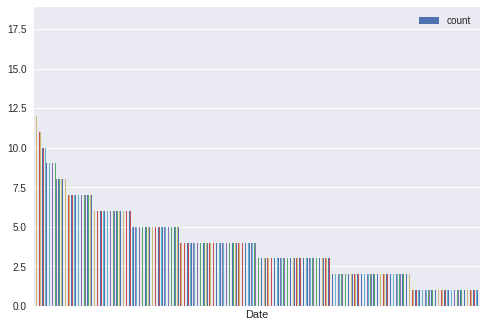

In [14]:
crimeSundayDowntown_pd = crimeSundayDowntown.toPandas()
crimeSundayDowntown_pd.plot.bar(x='Date',y='count')

# hide x ticks
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks([])

,count
count,754.000000
mean,3.876658
std,2.403939
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,18.000000


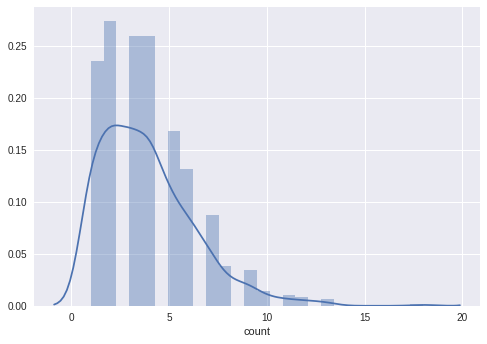

In [64]:
sns.distplot(crimeSundayDowntown_pd['count'])
crimeSundayDowntown_pd.describe()

[]

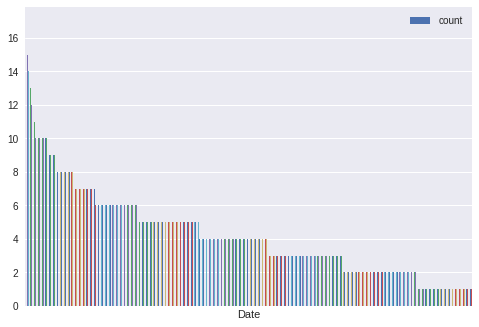

In [59]:
# compare with Monday & Thursday statistic
crimeMondayDowntown = spark.sql("SELECT Date, COUNT(*) as count \
                                FROM sf_crime \
                                WHERE X>=-122.4087 AND X <= -122.3933 AND Y<=37.7966 AND Y>= 37.7936 AND DayOfWeek = 'Monday'\
                                GROUP BY Date ORDER BY count DESC")
crimeMondayDowntown_pd = crimeMondayDowntown.toPandas()
crimeMondayDowntown_pd = crimeMondayDowntown.toPandas()
crimeMondayDowntown_pd.plot.bar(x='Date',y='count')

# hide x ticks
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks([])

,count
count,773.000000
mean,4.216041
std,2.610491
min,1.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,17.000000


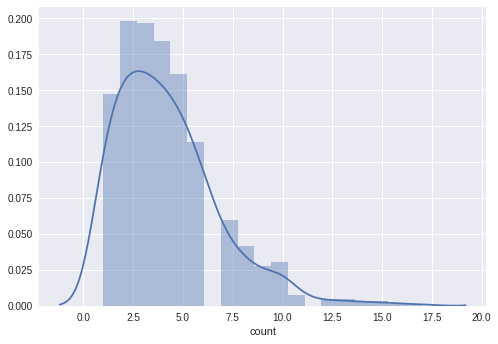

In [62]:
sns.distplot(crimeMondayDowntown_pd['count'])
crimeMondayDowntown_pd.describe()

[]

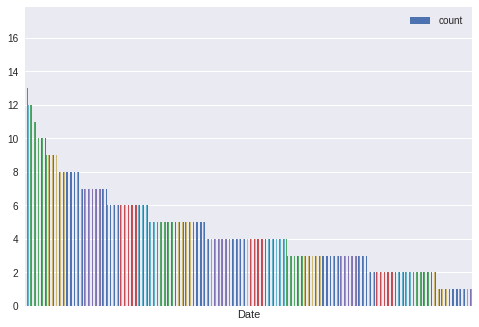

In [60]:
crimeThursdayDowntown = spark.sql("SELECT Date, COUNT(*) as count \
                                FROM sf_crime \
                                WHERE X>=-122.4087 AND X <= -122.3933 AND Y<=37.7966 AND Y>= 37.7936 AND DayOfWeek = 'Thursday'\
                                GROUP BY Date ORDER BY count DESC")
crimeThursdayDowntown_pd = crimeThursdayDowntown.toPandas()
crimeThursdayDowntown_pd = crimeThursdayDowntown.toPandas()
crimeThursdayDowntown_pd.plot.bar(x='Date',y='count')

# hide x ticks
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks([])

,count
count,769.000000
mean,4.423927
std,2.495256
min,1.000000
25%,3.000000
50%,4.000000
75%,6.000000
max,17.000000


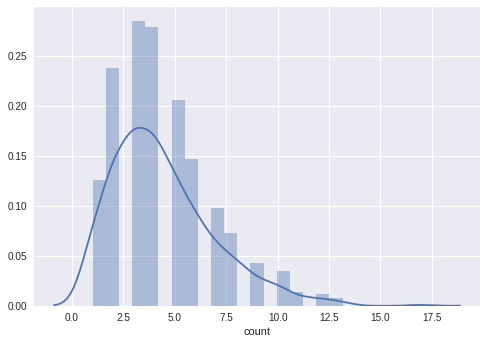

In [63]:
sns.distplot(crimeThursdayDowntown_pd['count'])
crimeThursdayDowntown_pd.describe()

# Analysis the number of crime in each month of 2015, 2016, 2017, 2018.
There is relatively large growth of number of crimes when May and October in SF compared with each year and all years combined. It is not recommended for tourists to travel to SF at these months and all residents should be more alert.

In [16]:
def get_month_and_year(str):
  return str[:2] + str[5:]

spark.udf.register("extracttime", get_month_and_year)

crimeEachMonth = spark.sql("select time as month_year, count(*) as number From (SELECT extracttime(Date) as time From sf_crime) Group by time Order by time ASC")
crimeEachMonth.show()

+----------+------+
|month_year|number|
+----------+------+
|   01/2003| 12956|
|   01/2004| 13086|
|   01/2005| 12340|
|   01/2006| 11833|
|   01/2007| 11601|
|   01/2008| 11984|
|   01/2009| 11929|
|   01/2010| 11370|
|   01/2011| 11634|
|   01/2012| 11629|
|   01/2013| 12757|
|   01/2014| 12777|
|   01/2015| 13606|
|   01/2016| 12967|
|   01/2017| 13084|
|   01/2018| 12031|
|   02/2003| 11924|
|   02/2004| 11933|
|   02/2005| 10691|
|   02/2006| 10772|
+----------+------+
only showing top 20 rows



[]

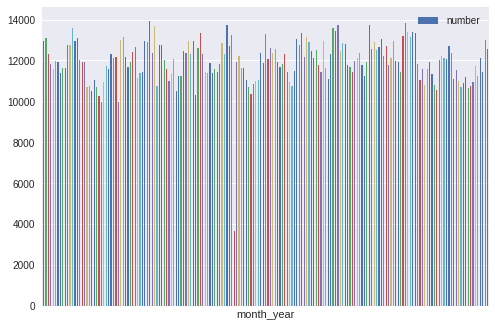

In [17]:
crimeEachMonth_pd = crimeEachMonth.toPandas()
crimeEachMonth_pd.plot(kind='bar',x='month_year',y='number')

# hide x ticks
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks([])

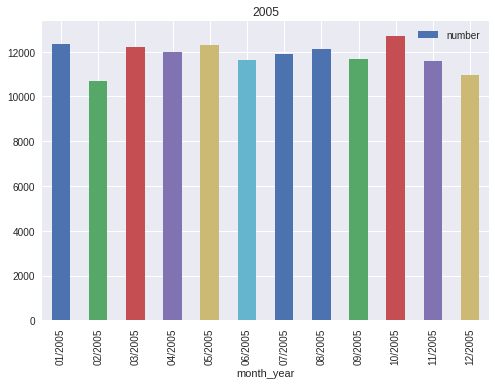

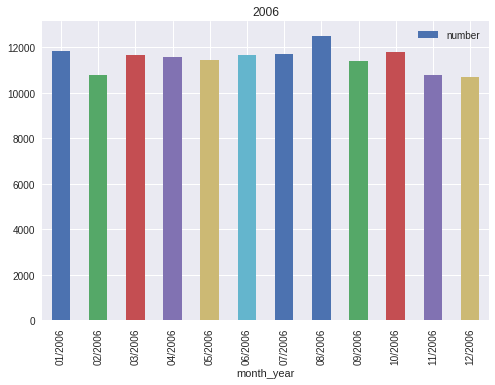

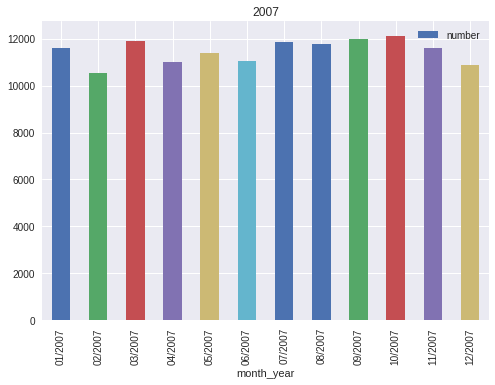

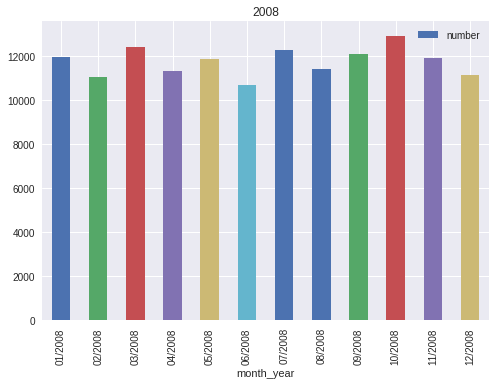

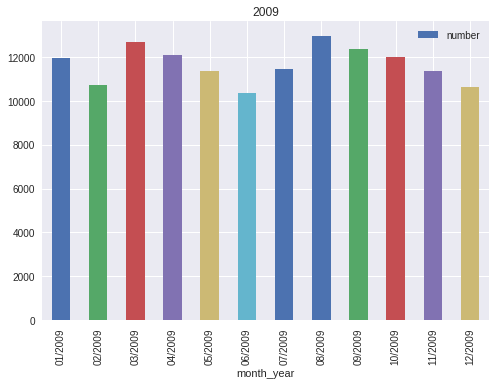

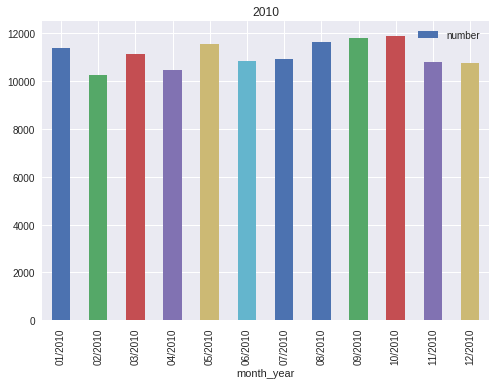

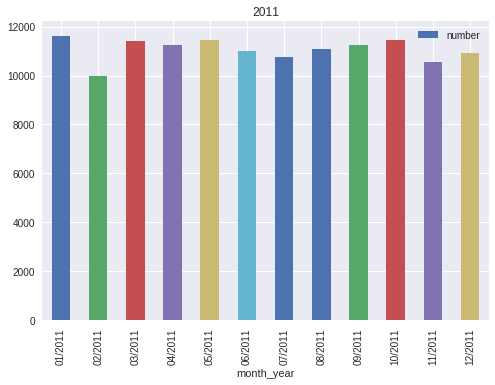

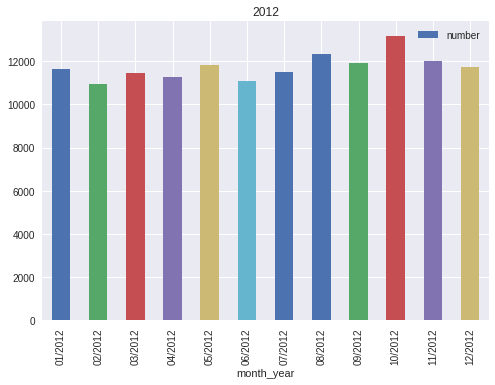

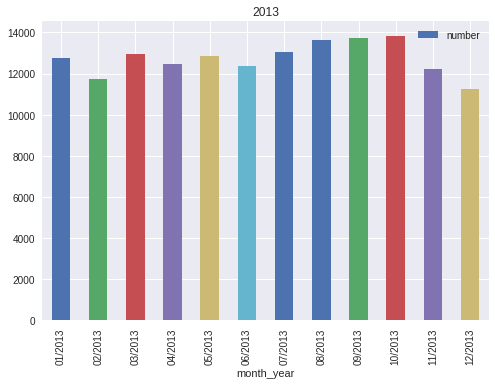

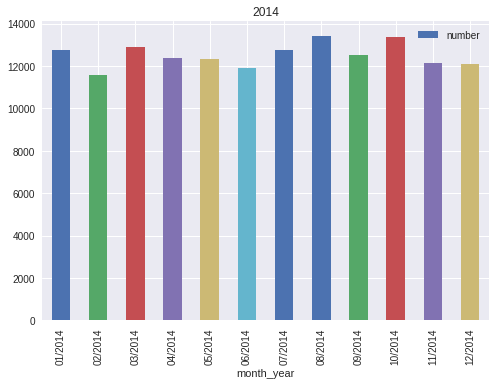

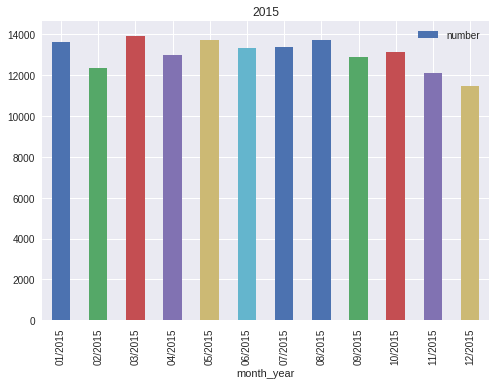

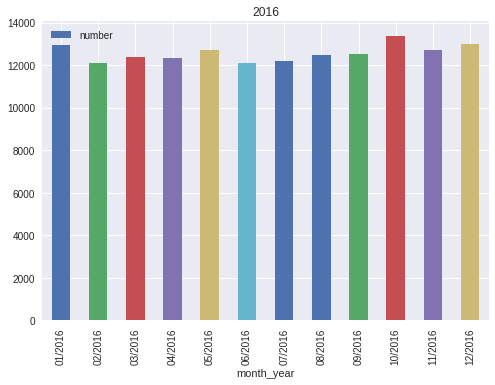

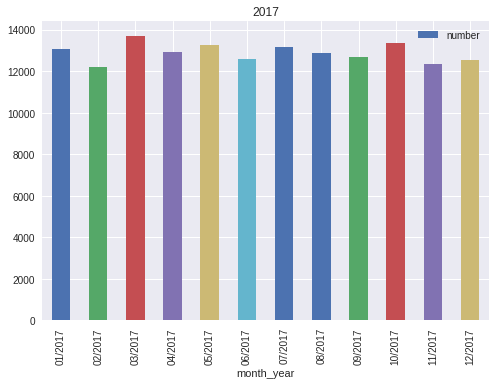

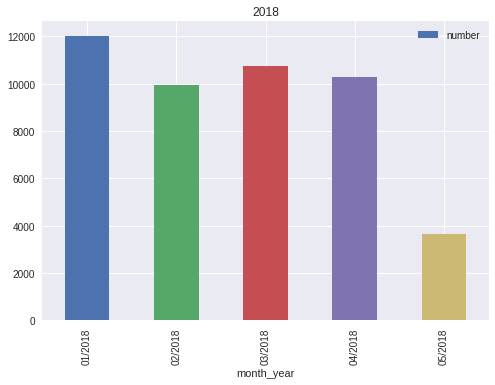

In [18]:
# analyse a more seperate data
Years = [str(i) for i in range(2005, 2019)]
for year in Years:
  prefix_command =  "select time as month_year, count(*) as number From (SELECT extracttime(Date) as time From sf_crime Where Date Like '%" + year + "') Group by time Order by time ASC"
  
  crimeEachMonthPerYear = spark.sql(prefix_command)
  crimeEachMonthPerYear_pd = crimeEachMonthPerYear.toPandas() 
  
  crimeEachMonthPerYear_pd.plot(kind='bar',x='month_year',y='number', title = year)

+-----+------+
|month|number|
+-----+------+
|   01|197584|
|   02|178619|
|   03|197580|
|   04|189834|
|   05|187747|
+-----+------+
only showing top 5 rows



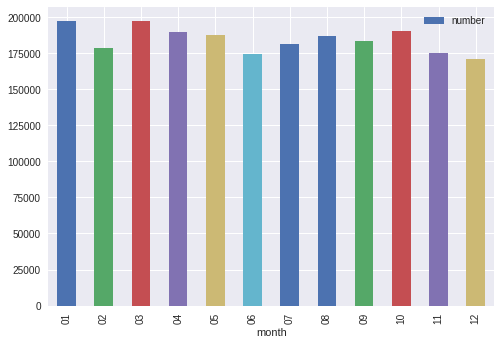

In [19]:
# analyse the distribution over whole data based on month

def get_month(s) : return s[:2]

spark.udf.register("extractmonth", get_month)

crimeEachMonthWhole = spark.sql("Select month, count(*) as number from(Select extractmonth(Date) as month From sf_crime) Group by month Order by month")
crimeEachMonthWhole.show(5)

crimeEachMonthWhole_pd = crimeEachMonthWhole.toPandas()
crimeEachMonthWhole_pd.plot.bar(x = 'month', y = 'number')

# Analysis the number of crime w.r.t the hour in certian day like 2015/12/15, 2016/12/15, 2017/12/15, 2018/10/15.

In general, at 12p.m. and 18p.m., the number of crimes will reach to peaks. Meanwhile, more crimes happened in the evening (18 - 22p.m.) and less in the early morning.

In [20]:
def get_hour(str):  return str[:2] 

spark.udf.register("extracthour", get_hour)

crimeCertainDate = spark.sql( "SELECT extracthour(Time) as hour, Date , Count(*) as number \
                              FROM sf_crime WHERE Date IN ('12/15/2015', '12/15/2016', '12/15/2017', '10/15/2018') \
                              Group by hour, Date Order by Date, hour")
crimeCertainDate.show(5)

+----+----------+------+
|hour|      Date|number|
+----+----------+------+
|  00|12/15/2015|    15|
|  01|12/15/2015|     6|
|  02|12/15/2015|     5|
|  03|12/15/2015|     4|
|  04|12/15/2015|    10|
+----+----------+------+
only showing top 5 rows



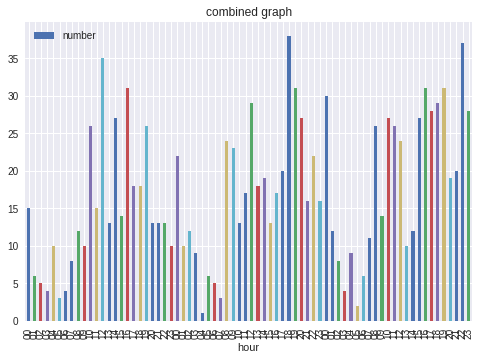

In [21]:
# overview

crimeCertainDate_pd = crimeCertainDate.toPandas()
crimeCertainDate_pd.plot(kind='bar',x='hour',y='number', title = 'combined graph')

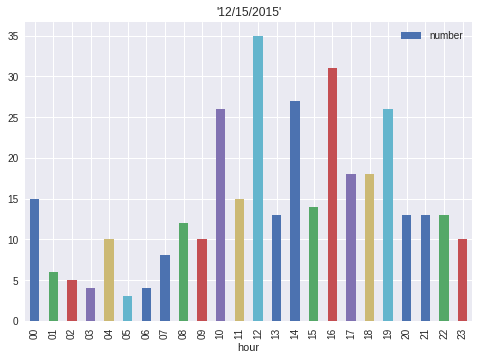

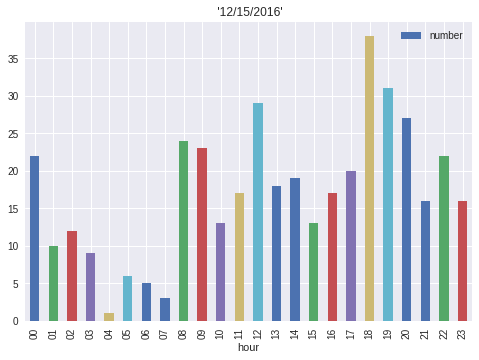

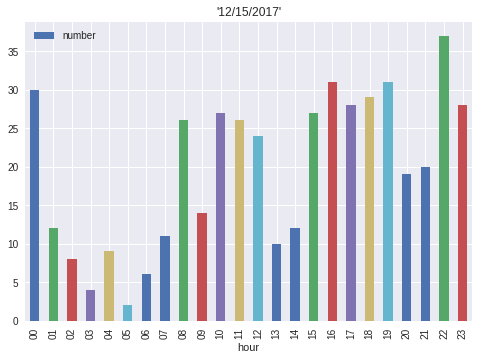

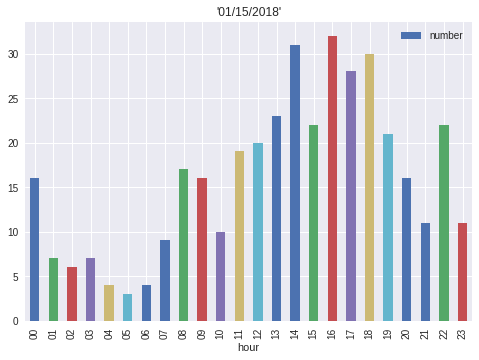

In [22]:
Days = ["'12/15/2015'"," '12/15/2016'", "'12/15/2017'", "'01/15/2018'"]

for Day in Days:
  prefix_command =  "SELECT extracthour(Time) as hour, Date , Count(*) as number \
                              FROM sf_crime WHERE Date = " + Day + " \
                              Group by hour, Date Order by Date, hour"
  
  crimeChooseDate = spark.sql(prefix_command)
  crimeChooseDate_pd = crimeChooseDate.toPandas() 
  
  crimeChooseDate_pd.plot(kind='bar',x='hour',y='number', title = Day)

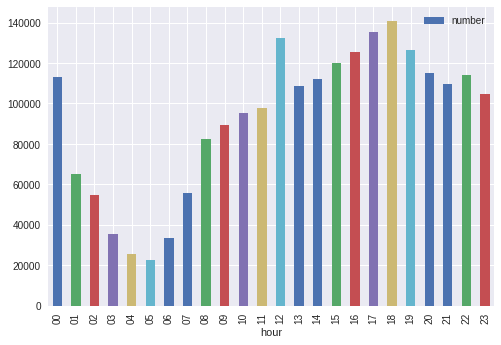

In [23]:
crimeDayPeriodCombined = spark.sql("SELECT extracthour(Time) as hour, Count(*) as number \
                                    FROM sf_crime \
                                    Group by hour Order by hour")
crimeDayPeriodCombined_pd = crimeDayPeriodCombined.toPandas()
crimeDayPeriodCombined_pd.plot.bar(x = "hour", y = 'number')

# Combined analysis
(1) Step1: Find out the top-3 danger disrict

(2) Step2: find out the crime event w.r.t category and time (hour) from the result of step 1

(3) give your advice to distribute the police based on your analysis results

The police DP should assign more forces as the time approaches 18 a.m. in Southern, Mission, and Northern areas.

In [24]:
#step1

#define danger as the number of crimes and attach a list of resolution rate

crimeTop3Danger = spark.sql("SELECT PdDistrict, COUNT(*)*100/(SELECT COUNT(*) FROM sf_crime) AS percetage_of_resolution, COUNT(*) as count From sf_crime GROUP BY PdDistrict ORDER BY count DESC LIMIT 3")
crimeTop3Danger.show(5)

+----------+-----------------------+------+
|PdDistrict|percetage_of_resolution| count|
+----------+-----------------------+------+
|  SOUTHERN|     18.048788636150217|399785|
|   MISSION|      13.54730242200536|300076|
|  NORTHERN|      12.31196592000809|272713|
+----------+-----------------------+------+



In [25]:
#step2

crimeTop3DangerCategoryAndTime = spark.sql("SELECT category, hour, COUNT(category) AS count \
                                            FROM (SELECT extracthour(Time) as hour, category FROM sf_crime WHERE PdDistrict in ('SOUTHERN', 'MISSION', 'NORTHERN')) \
                                            GROUP BY category, hour ORDER BY hour ASC, count DESC")
crimeTop3DangerCategoryAndTime.show(5)

+--------------+----+-----+
|      category|hour|count|
+--------------+----+-----+
| LARCENY/THEFT|  00|10093|
|OTHER OFFENSES|  00| 7749|
|  NON-CRIMINAL|  00| 5223|
|       ASSAULT|  00| 4724|
|     VANDALISM|  00| 2681|
+--------------+----+-----+
only showing top 5 rows



In [26]:
# to limit the significant crimes to be plotted on the graph, choose top 5 dangerous crimes(which occur most frequently) to be displayed on the graph

crimeTop3DangerCategoryAndTimeLimit = spark.sql("SELECT category, hour, COUNT(category) AS count \
                                            FROM (SELECT extracthour(Time) as hour, category FROM sf_crime WHERE PdDistrict in ('SOUTHERN', 'MISSION', 'NORTHERN')) \
                                            Where category in ('LARCENY/THEFT', 'OTHER OFFENSES', 'NON-CRIMINAL', 'ASSAULT', 'VEHICLE THEFT')\
                                            GROUP BY category, hour ORDER BY hour ASC, count DESC")

crimeTop3DangerCategoryAndTimeLimit.show(5)

+--------------+----+-----+
|      category|hour|count|
+--------------+----+-----+
| LARCENY/THEFT|  00|10093|
|OTHER OFFENSES|  00| 7749|
|  NON-CRIMINAL|  00| 5223|
|       ASSAULT|  00| 4724|
| VEHICLE THEFT|  00| 1568|
+--------------+----+-----+
only showing top 5 rows



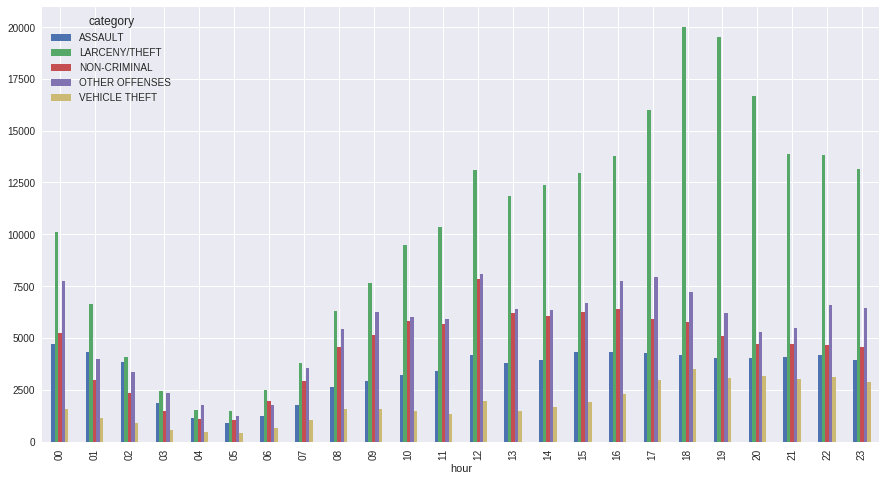

In [29]:
crimeTop3DangerCategoryAndTimeLimit_pd = crimeTop3DangerCategoryAndTimeLimit.toPandas()

plt.figure(figsize = (15,8))

pd.pivot_table(data = crimeTop3DangerCategoryAndTimeLimit_pd, index = 'hour', columns = 'category', values = 'count').plot(kind = 'bar', ax = plt.gca())

# For different category of crime, find the percentage of resolution. Based on the output, give your hints to adjust the policy.

I would recommend put more time and officers on the crimes that has low resolution rate and low cost to solve the crime. For example, the resolution rate of fraud is low, but it is easier to track the bank account to find the criminal. 

In [30]:
crimeResolutionPercentage = spark.sql("SELECT a.category, COUNT(*)*100/b.all AS percentage\
                                      FROM sf_crime AS a\
                                      JOIN (SELECT category, Count(*) AS all FROM sf_crime GROUP BY category) AS b \
                                      ON a.category = b.category \
                                      WHERE Resolution != 'NONE' \
                                      GROUP BY a.category, b.all\
                                      ORDER BY percentage DESC")
crimeResolutionPercentage.show(5)

+--------------------+-----------------+
|            category|       percentage|
+--------------------+-----------------+
|        PROSTITUTION|94.91048440213162|
|            WARRANTS| 94.5925684806518|
|DRIVING UNDER THE...| 94.4111424541608|
|       DRUG/NARCOTIC|91.41421740729595|
|         LIQUOR LAWS|88.95420034288513|
+--------------------+-----------------+
only showing top 5 rows



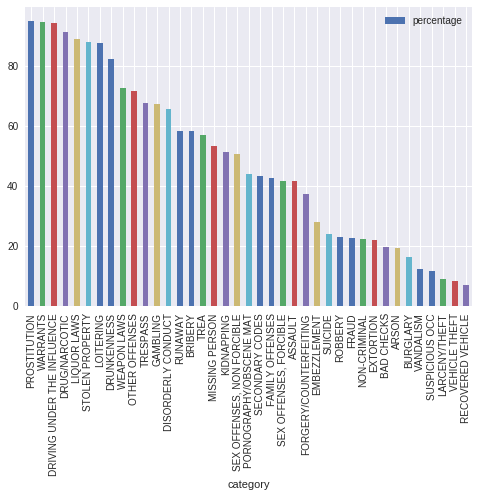

In [32]:
crimeResolutionPercentage_pd = crimeResolutionPercentage.toPandas()
crimeResolutionPercentage_pd.plot.bar(x = 'category', y = 'percentage')

# visualize the spatial distribution of crimes and run a kmeans clustering algorithm

In [55]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

crimeKmeans = spark.sql("SELECT X, Y\
                     FROM sf_crime")
Features_Col = ['X', 'Y']
crimeKmeans = crimeKmeans.select(crimeKmeans.X.cast("double"), crimeKmeans.Y.cast("double"))
vecAssembler = VectorAssembler(inputCols=Features_Col, outputCol="features")
crimeKmeansFeatures = vecAssembler.transform(crimeKmeans).select('features')
kmeans = KMeans().setK(25).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(crimeKmeansFeatures)
predictions = model.transform(crimeKmeansFeatures)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.5191165967528286
Cluster Centers: 
[-122.42492031   37.76758915]
[-120.5   90. ]
[-122.4567009   37.7185018]
[-122.49828233   37.74328586]
[-122.47632041   37.72339513]
[-122.4137929    37.78387586]
[-122.39164696   37.72263039]
[-122.44702214   37.7730638 ]
[-122.426199     37.74151789]
[-122.50013027   37.77141948]
[-122.41823654   37.7132914 ]
[-122.4338471    37.78989197]
[-122.46937089   37.76422687]
[-122.41378913   37.80165608]
[-122.39922257   37.75640941]
[-122.38674151   37.73419108]
[-122.40382461   37.71762822]
[-122.39922392   37.79000059]
[-122.44902913   37.74627532]
[-122.47065328   37.78062649]
[-122.47820007   37.74598929]
[-122.4048315    37.77523994]
[-122.41630171   37.7559925 ]
[-122.40743665   37.73469612]
[-122.43693412   37.7217102 ]


In [38]:
!pip install plotly

import plotly
import plotly.plotly as py
import plotly.graph_objs as go

In [56]:
plotly.tools.set_credentials_file(username='zsxing', api_key='BXWLiZgMMtpTggipAtCm')

mapbox_access_token ="pk.eyJ1IjoienN4aW5nIiwiYSI6ImNqdHMzZHBoZjB3cG00Ym5yM3M1OWRjNHIifQ.h9onuTetBhJ2rNuKgwAC9g"

data = [
    go.Scattermapbox(
        lat=[center[1] for center in centers],
        lon=[center[0] for center in centers],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=['Montreal'],
    )
]

layout = go.Layout(
    autosize=True,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat= 37.773972,
            lon= -122.431297
        ),
        pitch=0,
        zoom=10
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Montreal Mapbox')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~zsxing/0 or inside your plot.ly account where it is named 'Montreal Mapbox'


# Conclusion

As one of the global economical center, San Francisco also shows a kind of uncertainty because of crimes.

Based on this project, people can gain an overview of crimes happened from 2005 to 2018 in San Fransico. The graphs and charts show the categories of crimes, crime distribution over different police department districts, examine certain year, month, day, and even hours in a day of crime distribution. Find the general pattern for these distributions and give advise on how to allocate police resources against crimes to reduce crime from happening or increase resolution rate. Also gave advice for tourists for traveling regarding their safety. Finally, used K means algorithm to find top 25 crime cluster and concentrated area.